<a href="https://colab.research.google.com/github/nafanur/cancer_tumor_logistic_regression/blob/main/UAS_BIG_DATA_ANALYTICS_10060122030_NAFA_NURHANIFAH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
# IMPORT pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from pyspark.mllib.stat import Statistics

# import untuk regresi logistik
from pyspark.ml.feature import VectorAssembler # gabungkan vektor predictor menjadi satu kolom
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# start spark session

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local').getOrCreate() ##spark object

# load data

In [ ]:
path='/content/drive/MyDrive/Colab Notebooks/cancer_tumor.csv'

In [ ]:
df1=spark.read.csv(path,inferSchema=True, header=True)
df1.show(6)
# analisis regresi logistik: mengklasifikasikan tumor sebagai ganas atau jinak berdasarkan prediktor ini
# diagnosis (string): apakah kanker itu ganas atau tidak (M=ganas;B:jinak)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

## convert response variable M=1 and B=0

Ubah string menjadi numerik
M(𝑚𝑎𝑙𝑖𝑔𝑛𝑎𝑛𝑡/ganas)=1 dan
B(𝑏𝑒𝑛𝑖𝑔𝑛/jinak)=0

In [ ]:
df2=df1.withColumn("diagnosis", fn.when(fn.col("diagnosis") == 'M' , 1).otherwise(0)) # menggunakan fn
df2.show()

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [ ]:
# menampilkan nama variabel kolom dari dataset kanker tumor
print(df2.columns)
print("Jumlah kolom:", len(df2.columns))

['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Jumlah kolom: 31


In [ ]:
# membuat kolom vektor prediktor
Pred_corr= ['radius_mean','texture_mean',
'area_mean','perimeter_mean','compactness_mean','radius_se','area_se','perimeter_se','radius_worst',
'texture_worst','area_worst','concavity_worst','symmetry_worst']
### diagnosis --> variabel respon (Y))

In [ ]:
# Creating vector column which will contain all the feature columns (fitur kolom)
vector_col = "Predictors"
assembler = VectorAssembler(inputCols=Pred_corr,
                            outputCol=vector_col) ##assemble the inputs and outputs
output = assembler.transform(df2)

In [ ]:
# Selecting only needful columns
vector=output.select("Predictors","diagnosis") ## beberapa variabel X, variabel target/respon (Y)

In [ ]:
vector.show(10,truncate=False)

+-------------------------------------------------------------------------------------+---------+
|Predictors                                                                           |diagnosis|
+-------------------------------------------------------------------------------------+---------+
|[17.99,10.38,1001.0,122.8,0.2776,1.095,153.4,8.589,25.38,17.33,2019.0,0.7119,0.4601] |1        |
|[20.57,17.77,1326.0,132.9,0.07864,0.5435,74.08,3.398,24.99,23.41,1956.0,0.2416,0.275]|1        |
|[19.69,21.25,1203.0,130.0,0.1599,0.7456,94.03,4.585,23.57,25.53,1709.0,0.4504,0.3613]|1        |
|[11.42,20.38,386.1,77.58,0.2839,0.4956,27.23,3.445,14.91,26.5,567.7,0.6869,0.6638]   |1        |
|[20.29,14.34,1297.0,135.1,0.1328,0.7572,94.44,5.438,22.54,16.67,1575.0,0.4,0.2364]   |1        |
|[12.45,15.7,477.1,82.57,0.17,0.3345,27.19,2.217,15.47,23.75,741.6,0.5355,0.3985]     |1        |
|[18.25,19.98,1040.0,119.6,0.109,0.4467,53.91,3.18,22.88,27.66,1606.0,0.3784,0.3063]  |1        |
|[13.71,20.83,577.9,

# Split data into training and testing

In [ ]:
### split data into training and testing
train_data,test_data=vector.randomSplit([0.8,0.2])
## 80% for training, 20% for testing

In [ ]:
train_data.count()

452

In [ ]:
test_data.count()

117

# Model regresi logistik

In [ ]:
# menginisialisasi model regresi logistik
regressor=LogisticRegression(featuresCol="Predictors",labelCol="diagnosis",maxIter=1000) # iterasi/pengulangan max sampai ke 1000

In [ ]:
##predict on training dataset
lr_model = regressor.fit(train_data) ##.fit

In [ ]:
lr_model.summary

In [ ]:
lr_model.intercept

-29.42913779812215

In [ ]:
lr_model.coefficients

DenseVector([-4.5222, -0.0385, 0.007, 0.4064, -13.2217, -3.263, 0.1448, 0.0757, 2.1482, 0.2902, 0.0005, 6.1783, 17.8698])

### Membandingkan "diagnosis" dari data testing dan hasil dari prediksi model

In [ ]:
predictions = lr_model.transform(test_data)

In [ ]:
# data testing
diagnosis_values = predictions.select("diagnosis").rdd.flatMap(lambda x: x).collect()
for i in range(0, len(diagnosis_values), 10):
    print(diagnosis_values[i:i+10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 1, 1]
[0, 1, 0, 1, 0, 0, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1]


In [ ]:
# data hasil prediksi
predicted_values = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
for i in range(0, len(diagnosis_values), 10):
    print(predicted_values[i:i+10])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]
[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


# plotting Area Under Curve (AUC) as accuracy level

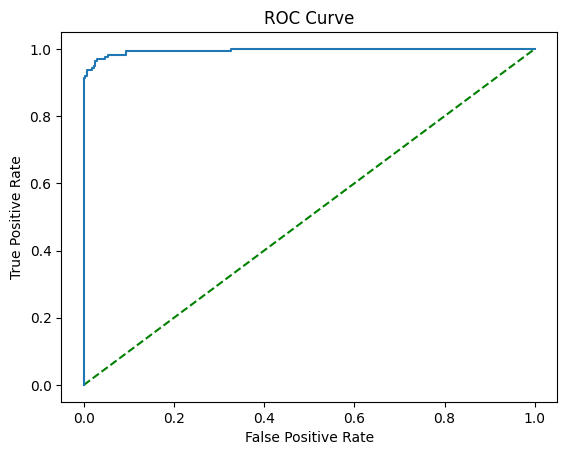

TrainSet areaUnderROC: 0.9954834566059624


In [ ]:
lr_model_summary = lr_model.summary
roc = lr_model_summary.roc.toPandas()

plt.plot([0, 1], [0, 1], 'g--')
plt.plot(roc['FPR'],roc['TPR'])

#FPR (False Positive Rate) di sumbu-x
#TPR (True Positive Rate) di sumbu-y
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderROC: ' + str(lr_model_summary.areaUnderROC))

Interpretasi:

Setelah itu, dalam regresi logistik, kita bisa memvisualisasikan kualitas model dengan menggunakan grafik Area Under the Curve (AUC). Maka saya buat variabel baru bernama LR_model_summary untuk menyimpan ringkasan hasil model.
Dengan menggunakan fungsi "summary", kita bisa melihat hasil evaluasi dari model tersebut. Kemudian menampilkan grafik AUC-nya.
Dan diperoleh, Nilai AUC yang dihasilkan adalah 0.99.

Artinya: semakin besar nilai AUC, maka semakin akurat model klasifikasi binernya (dalam hal membedakan antara dua kelas — misalnya: tumor ganas vs jinak).

# Evaluasi model pada data testing

In [ ]:
# evaluasi klasifikasi biner
lr_model_test = regressor.fit(test_data) ##.fit

In [ ]:
lr_model_test = lr_model.transform(test_data) ##.fit

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='diagnosis')
print('Test Area Under ROC', evaluator.evaluate(lr_model_test))
# menghitung luas dibawah kurva ROC

Test Area Under ROC 0.9957264957264957


Model ini sangat bagus dalam membedakan antara dua kelas (termasuk tumor jinak dan tumor ganas), karena nilai AUC-nya mendekati 1 (0.986). Ini berarti model bisa membedakan data positif dan negatif dengan tingkat akurasi yang sangat tinggi, hampir sempurna.

## Mencoba menerapkan model regresi logistik ke data yang baru

In [ ]:
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, col

# 1. Ambil input manual dari pengguna
input_data = []
for fitur in Pred_corr:
    nilai = float(input(f"Masukkan nilai untuk {fitur}: "))
    input_data.append(nilai)

# 2. Buat DataFrame dari input
row_input = Row(*Pred_corr)
data_baru = spark.createDataFrame([row_input(*input_data)])

# 3. Gabungkan semua kolom fitur jadi satu kolom vektor "Predictors"
assembler = VectorAssembler(inputCols=Pred_corr, outputCol="Predictors")
data_baru_vector = assembler.transform(data_baru)

# 4. Gunakan model regresi logistik yang sudah dilatih untuk prediksi
hasil = lr_model.transform(data_baru_vector)

# 5. Tampilkan hasil prediksi (M atau B)
hasil = hasil.withColumn("diagnosis_prediksi",
                         when(col("prediction") == 1.0, "M").otherwise("B"))

hasil.select("prediction", "diagnosis_prediksi").show()

Masukkan nilai untuk radius_mean: 15
Masukkan nilai untuk texture_mean: 15
Masukkan nilai untuk area_mean: 100
Masukkan nilai untuk perimeter_mean: 100
Masukkan nilai untuk compactness_mean: 0.5
Masukkan nilai untuk radius_se: 0.5
Masukkan nilai untuk area_se: 100
Masukkan nilai untuk perimeter_se: 7
Masukkan nilai untuk radius_worst: 20
Masukkan nilai untuk texture_worst: 20
Masukkan nilai untuk area_worst: 2000
Masukkan nilai untuk concavity_worst: 0.5
Masukkan nilai untuk symmetry_worst: 0.5
+----------+------------------+
|prediction|diagnosis_prediksi|
+----------+------------------+
|       1.0|                 M|
+----------+------------------+

